# **02 - Model Construction**
## **Convolutional Neural Network (CNN) - Pretrained ResNet50 Model (PyTorch)**

### **Imports & Data Loading**

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader, random_split
import splitfolders
cudnn.benchmark = True
plt.ion()   # interactive mode

In [23]:
# Train test split into own folders (80/20 split)
splitfolders.ratio("data/tiled_images/keras", output="data/tiled_images/pytorch", seed=123, ratio=(0.8, 0.2), group_prefix=None, move=True) 

In [24]:
# Data augmentation and normalization for training, and just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/tiled_images/pytorch/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [25]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

### **Data Visualization**

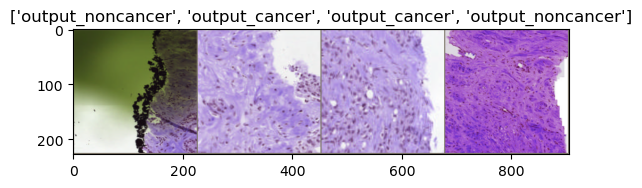

In [26]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### **Functions for Model Training and Visualizing Model Predictions**

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [28]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### **Finetuning the ConvNet**
#### Loading a Pretrained ResNet 50 model with IMAGENET1K_V2 weights and resetting the final fully connected layer

In [29]:
model = models.resnet50(weights='IMAGENET1K_V2')
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### **Model Training** 
#### Trained the model for 15 epochs and reached a maximum validation accuracy of 0.893.

In [30]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.4186 Acc: 0.8219
val Loss: 0.3492 Acc: 0.8703

Epoch 1/14
----------
train Loss: 0.3761 Acc: 0.8473
val Loss: 0.3351 Acc: 0.8801

Epoch 2/14
----------
train Loss: 0.3648 Acc: 0.8536
val Loss: 0.3153 Acc: 0.8823

Epoch 3/14
----------
train Loss: 0.3570 Acc: 0.8571
val Loss: 0.3327 Acc: 0.8776

Epoch 4/14
----------
train Loss: 0.3533 Acc: 0.8588
val Loss: 0.3274 Acc: 0.8848

Epoch 5/14
----------
train Loss: 0.3498 Acc: 0.8602
val Loss: 0.3342 Acc: 0.8831

Epoch 6/14
----------
train Loss: 0.3456 Acc: 0.8631
val Loss: 0.3117 Acc: 0.8884

Epoch 7/14
----------
train Loss: 0.3348 Acc: 0.8683
val Loss: 0.3112 Acc: 0.8904

Epoch 8/14
----------
train Loss: 0.3308 Acc: 0.8701
val Loss: 0.3020 Acc: 0.8916

Epoch 9/14
----------
train Loss: 0.3294 Acc: 0.8704
val Loss: 0.3050 Acc: 0.8918

Epoch 10/14
----------
train Loss: 0.3289 Acc: 0.8703
val Loss: 0.3045 Acc: 0.8911

Epoch 11/14
----------
train Loss: 0.3273 Acc: 0.8717
val Loss: 0.3109 Acc: 0.8921

Ep

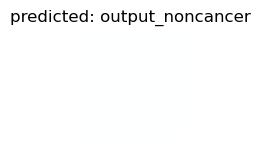

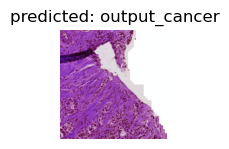

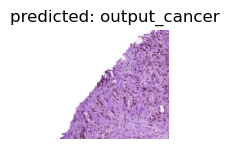

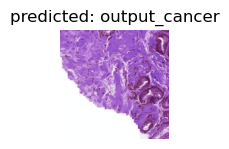

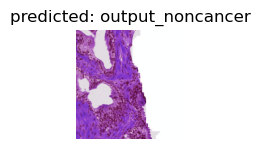

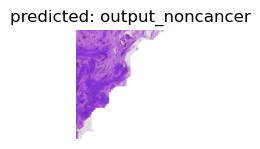

In [31]:
visualize_model(model)

### **Inference on custom images**
#### Use the trained model to make predictions on custom images and visualize the predicted class labels along with the images.

In [35]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path).convert('RGB')
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

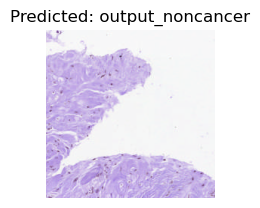

In [36]:
visualize_model_predictions(
    model,
    img_path="data/tiled_images/output/00f6ea010b008e7b3635910a13b165a5_(512, 3840)_noncancer.png"
)

plt.ioff()
plt.show()

### **Citations:**
- https://github.com/jfilter/split-folders
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://pytorch.org/vision/main/models.html